# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [39]:
# Import libraries and packages
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models as gensimvis

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [62]:
# add any additional libaries you need here
# !pip install spacy
# !python -m spacy download en_core_web_sm
# import nltk
# nltk.download('brown')

import matplotlib.pyplot as plt
# import pyLDAvis.sklearn
import gensim
from gensim import corpora
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from gensim.matutils import Sparse2Corpus

In [12]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [14]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [15]:
# Define list of categories from Brown corpus
categories = ['editorial','government','news','romance','hobbies'] 

# Initialize lists
category_list = []
file_ids = []
texts = []

# Loop through defined categories within corpus and build dataframe
for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

# Create Pandas dataframe       
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

# Dataframe shape
df.shape

(166, 3)

In [16]:
# Add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

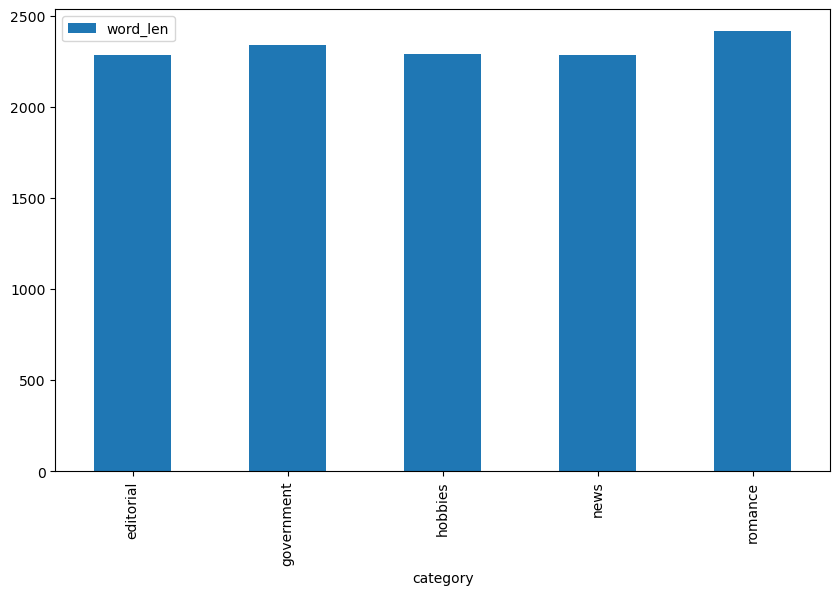

In [17]:
# Create matplotlib bar chart for each category with its mean length
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [20]:
# Convert collection of text to matrix of token counts
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)

# Create matrix with tokens and respective finds within document
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])

# Shape of text vector
count_text_vectors.shape

(166, 4941)

In [21]:
# Convert collection of text to matrix of token counts
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)

# Create matrix with tokens and respective finds within document
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])

# Shape of text vector
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The first matrix contains raw counts of words within the Brown corpus while the second contains TF-IDF scores of terms within it.
One can tell by the different techniques applied to each: CountVectorizes for the first and TfidfVectorizer for the second.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [23]:
# Initialize NMF model
nmf_text_model = NMF(n_components=5, random_state=314)

# Fit the NMF model
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

# Extract topic-word matrix from the fitted model
H_text_matrix = nmf_text_model.components_

In [25]:
# Print top topics, words, and respective weight scores
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [26]:
# Create a DataFrame from the document-topic matrix `W_text_matrix`
W_df = pd.DataFrame(W_text_matrix, columns=[f'Topic_{i}' for i in range(W_text_matrix.shape[1])])

# Add the original Brown categories to `W_df` for comparison
W_df['category'] = df['category']

# Assign each document to the topic with the highest weight
W_df['assigned_topic'] = W_df[[f'Topic_{i}' for i in range(W_text_matrix.shape[1])]].idxmax(axis=1)

# Tally the original categories for each topic
tally = W_df.groupby('assigned_topic')['category'].value_counts().unstack(fill_value=0)

# Display the tally for interpretation
print(tally)

category        editorial  government  hobbies  news  romance
assigned_topic                                               
Topic_0                20           4        0     8        0
Topic_1                 4           0        8     0       29
Topic_2                 2          26       26    11        0
Topic_3                 0           0        1    17        0
Topic_4                 1           0        1     8        0


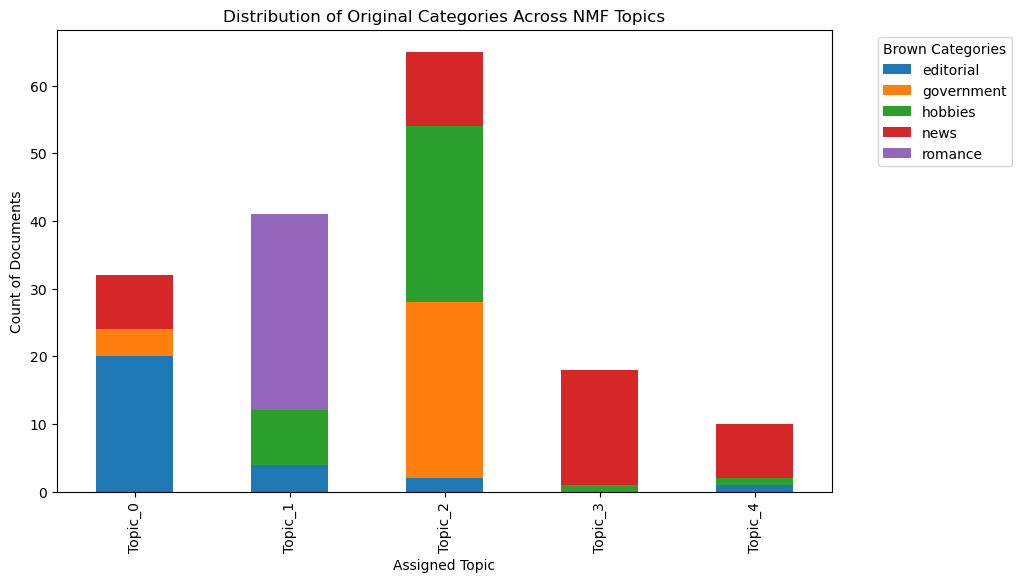

In [29]:
# Plot distribution to visualize how well topics align with original categories
tally.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Assigned Topic')
plt.ylabel('Count of Documents')
plt.title('Distribution of Original Categories Across NMF Topics')
plt.legend(title='Brown Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Overall, I think that further improvements are needed for this model to be optimal.
While good matches are found for topics such as #1 and #3, less clear matches are noted such as #0 and #2.
These topics show sparse classifications across each of the categories, suggesting that the model is having difficulties making the right predictions.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [30]:
# Initialize LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)

# Fit the LSA model
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)

# Extract topic-word matrix
H_lsa_matrix = lsa_text_model.components_

In [31]:
# Create a DataFrame from the document-topic matrix `W_lsa_matrix`
W_lsa_df = pd.DataFrame(W_lsa_matrix, columns=[f'Topic_{i}' for i in range(W_lsa_matrix.shape[1])])

# Add the original Brown categories to `W_lsa_df` for comparison
W_lsa_df['category'] = df['category']

# Assign each document to the topic with the highest weight
W_lsa_df['assigned_topic'] = W_lsa_df[[f'Topic_{i}' for i in range(W_lsa_matrix.shape[1])]].idxmax(axis=1)

# Tally the original categories for each topic
lsa_tally = W_lsa_df.groupby('assigned_topic')['category'].value_counts().unstack(fill_value=0)

# Display the tally for interpretation
print(lsa_tally)

category        editorial  government  hobbies  news  romance
assigned_topic                                               
Topic_0                27          30       36    34       21
Topic_1                 0           0        0     0        8
Topic_3                 0           0        0     3        0
Topic_4                 0           0        0     7        0


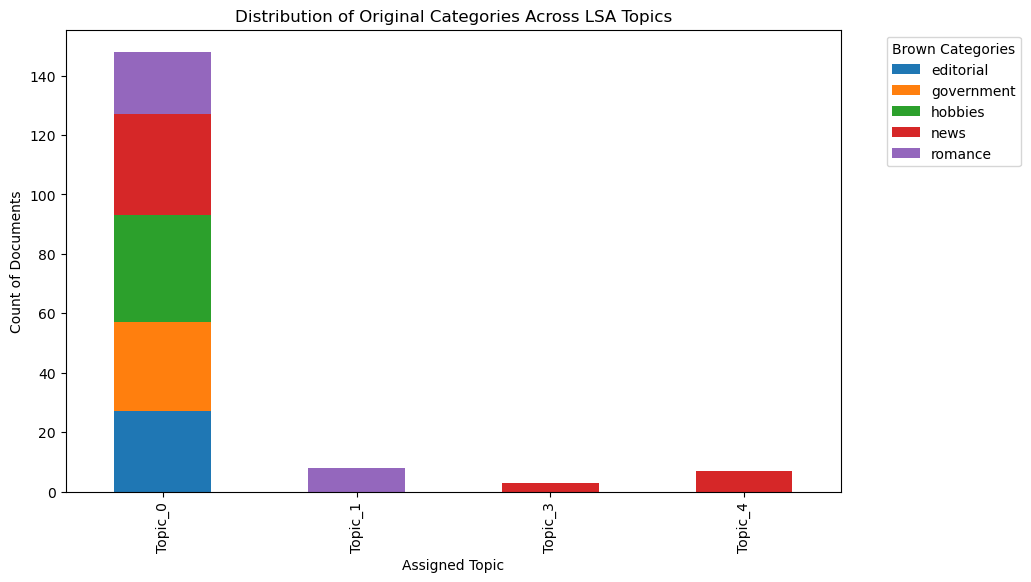

In [33]:
# Plot distribution to visualize how well topics align with original categories
lsa_tally.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Assigned Topic')
plt.ylabel('Count of Documents')
plt.title('Distribution of Original Categories Across LSA Topics')
plt.legend(title='Brown Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: I do not believe the model to be generalizing well.
The model seems to categorize topic 00 better than any other topics.

Q: What is your interpretation of the display topics output? 

A: The LSA model struggled with separating distinct themes for most topics, with Topic 0 being highly mixed and Topics 3 and 4 only partially capturing the news content. In contrast, Topic 1 showed a good match with the Romance category. Overall, this suggests that LSA may require further tuning or preprocessing to better align with the original categories of the Brown Corpus.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [48]:
# Convert the count vectorizer output into a format suitable for Gensim
corpus = Sparse2Corpus(count_text_vectors, documents_columns=False)

# Get the feature names from the count vectorizer
id2word = corpora.Dictionary([count_text_vectorizer.get_feature_names_out()])

# Fit the Gensim LDA model using the corpus and id2word dictionary
lda_gensim_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=314, passes=10)

In [49]:
# Prepare the visualization for the Gensim LDA model
lda_display = pyLDAvis.gensim_models.prepare(lda_gensim_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(lda_display)

Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model appears to be effective at identifying narrative or fiction-based content, which forms a distinct and cohesive topic.
However, the model struggles in some areas such as Government and Hobbies, indicating that  these categories likely share thematic or linguistic similarities. The LDA model recognizes the close relationship between factual reporting (news) and commentary or opinion (editorial), which i think often co-occur in news articles and media. That said, based on the pros and cons just mentioned, I believe the most significant inference I can observe is that because of the category overlapping, the model isn't at an optimal point just yet.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: overall, I think the LDA model gives a better fit. 

In [50]:
# Re-fit the LDA model using the count vectors
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_matrix = lda_text_model.fit_transform(count_text_vectors)

# Create a DataFrame from the document-topic matrix `W_lda_matrix`
W_lda_df = pd.DataFrame(W_lda_matrix, columns=[f'Topic_{i+1}' for i in range(W_lda_matrix.shape[1])])

# Add the original Brown categories to `W_lda_df` for comparison
W_lda_df['category'] = df['category']

# Assign each document to the topic with the highest weight
W_lda_df['assigned_topic'] = W_lda_df[[f'Topic_{i+1}' for i in range(W_lda_matrix.shape[1])]].idxmax(axis=1)

In [63]:
# Tally the original categories for each LDA-assigned topic
lda_tally = W_lda_df.groupby('assigned_topic')['category'].value_counts().unstack(fill_value=0)

# Display the tally using pandas display method
print(lda_tally)

category        editorial  government  hobbies  news  romance
assigned_topic                                               
Topic_1                 3           1       11     4       28
Topic_2                 1          12        9     3        0
Topic_3                21           3        2    32        1
Topic_4                 2           4        8     3        0
Topic_5                 0          10        6     2        0


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Topic prevalence quickly becomes evident. For instance, Topic 1 is the most prevalent in the corpus, suggesting it covers a broad or common theme across many documents. Topic 2 is the most distinct and least overlapping with other topics, indicating a unique thematic focus. Topic 3 & 4 show significant overlap, indicating that they likely cover similar or related themes. Also, key theme terms like state, government, mrs, and united suggest that some topics focus on governance, politics, and possibly personal stories or dialogues.
